In [1]:
from IPython.display import HTML, display, Image
HTML('''
<script src="https://cdnjs.cloudflare.com/ajax/libs/jquery/2.0.3/jquery.min.js "></script><script>code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.jp-CodeCell > div.jp-Cell-inputWrapper').hide();
 } else {
$('div.jp-CodeCell > div.jp-Cell-inputWrapper').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script><form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

<img src='hw3_banner.png' height='300'>

**MSDS 2023 Term 3 CPT1** | Rozz Charles Banquerigo, Gregory Mark del Carmen, Maria Loraine Menorca, BJ Enrik Yepes 

**Instructions**

Bak-Tang-Weisenfield Sandpile Model is one of the simplest Cellular Automata Model that shows self-organized criticality. The BTW Model creates a finite grid of "a pile of sand" that has an associated value that corresponds to the slope of the pile. This slope builds up as "grains of sand" (or "chips") are randomly placed onto the pile, until the slope exceeds a specific threshold value at which time that site collapses transferring sand into the adjacent sites, increasing their slope.

In The BTW Model has the following simple rule:
1. Initialize a zero-valued N X N grid. (Try N = 128)
1. **Drop** - For each iteration *t*, select a random grid and add 1 to the value
1. **Stability** - Check if the cell is stable, i.e. value of the selected random grid is greater than or equal to threshold of 4, If true:
    1. **Topple** - Redistribute the value of the cell to its neighbors (i.e. return to 0. Cells in the top, bottom, left, and right +1)
    1. Check the stability of neighbors and tople (Check if > 4 and so on)
    1. Repeat until all affected cells are stable
    1. *If the cell is at the edge, the grains **falls off** the grid and results in a net loss.* 
1. The toppling of the cell and its corresponding effect in the system is called an *Avalanche*. Count the number of cells affected by the avalanche and store for time *t*. This is called the Avalanche Size (*s*).
1. Iterate this process over large value of *t*.

**Questions**
1. Plot the time vs avalanche size. Describe the dynamics of the avalanche size. How would this plot change as you vary N?
1. Plot the histogram of avalanche sizes. What does this distribution look like? Try to change the x and y axis in the logarithm to make the plot more obvious.
1. Plot the histogram of waiting time between large avalanches (s > N). What distribution does this show?

*Hint - You should be getting a linear plot in log-log axis. This distribution was discussed in MDS. It is a characteristic of most complex systems. What are the implications of this distribution?*


In [2]:
# Simulation tools
from scipy.optimize import curve_fit
from tqdm import trange
import numpy as np
import itertools

# Plotting tools
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# Set global plotting parameters
custom_sns_params = {'lines.linewidth': 2, 'font.size': 11,
                     'axes.titlesize': 12, 'axes.labelsize': 11,
                     'xtick.labelsize': 9, 'ytick.labelsize': 9,
                     'legend.fontsize': 10, 'legend.fancybox': True,
                     'axes.spines.right': False, 'axes.spines.top': False,
                     'figure.figsize':(6, 4)}
sns.set_theme('notebook', style='ticks', rc=custom_sns_params)
colors = ['#393357', '#FFD400', '#00A5D3', '#009A57', '#6E3476']
custom_palette = sns.blend_palette(colors)
sns.set_palette(custom_palette)

randstate = 143
np.random.seed(randstate)

# define a global parameter figure counter
fig_n = 1
def fig_count():
    global fig_n
    fig_n += 1
    return fig_n

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-jy09fvhg because the default path (/home/mmenorca/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
def drop(grid):
    """
    Return the resulting grid after dropping a grain (i.e., adding 1
    to the values).
    """
    x, y = np.random.randint(1, len(grid)-1, size=(2))
    grid[x][y] += 1
    return grid

def topple_unstable(grid, thresh=4):
    """
    Return the resulting grid after toppling the unstable cells, and 
    the location of these cells.
    """
    unstable_locs = list(zip(*np.where(grid >= thresh)))
    for (x, y) in unstable_locs:       
        # topple neighbors
        neighbors = [[x+1,y], [x,y+1], [x-1,y], [x,y-1]]
        grid[x][y] -= thresh
        for n in neighbors:
            grid[n[0]][n[1]] += 1
    
    # topple edge
    for idx in range(len(grid)):
        grid[0][idx] = 0
        grid[-1][idx] = 0
        grid[idx][0] = 0
        grid[idx][-1] = 0
    
    return grid, unstable_locs

def sandpile(N=20, iterations=1000, thresh=4):
    """
    Return the resulting grid of the simulated sandpile model for
    a given size (N), and number of cells (grains).
    """
    grid = np.zeros([N, N])
    sizes = []
    for t in trange(iterations):
        s = []
        grid = drop(grid)
        while np.any(grid >= thresh) == True: # sandpile is unstable
            grid, unstable_locs = topple_unstable(grid)
            s.extend(unstable_locs)
        sizes.append(len(set(s)))
    return grid, sizes

def plot_sizes(Ns, fig_title, iters=5000):
    """
    Plot the avalanche size at different time steps.
    """
    fig, ax = plt.subplots(figsize=[14, 5], dpi=100)
    for N in Ns:
        _, sizes = sandpile(N=N, iterations=iters)
        ax.plot(sizes, label=f'N={N}')
    plt.xlabel('Time, $t$')
    plt.ylabel('Avalanche size, $s$')
    plt.legend(loc='upper left')
    plt.title(f'Fig. {fig_n}: {fig_title}')
    plt.show()
    _ = fig_count()
    
def fit_fxn(x,a,b):
    """
    Return the fitted Power Law distribution given the input values.
    """
    return a*np.power(x,b)
    
def plot_size_hist(sizes, fig_title):
    """
    Return the distribution of different avalanche sizes in logarithmic
    scale.
    """
    fig, ax = plt.subplots(figsize=[6, 4], dpi=100)
    freqs, bins = np.histogram(sizes)
    freqs, bins = freqs[1:], bins[1:-1]
    ax.set_xscale('log')
    ax.set_yscale('log')
    popt, pcov = curve_fit(fit_fxn, bins, freqs / sum(freqs))
    ax.plot(bins, fit_fxn(bins, *popt), 'k', label=f"$\gamma$ = {popt[1]:.2f}")
    ax.scatter(bins, freqs / sum(freqs))
    plt.xlabel('Avalanche size, $s$')
    plt.ylabel('Frequency, $f$')
    plt.legend()
    plt.title(f'Fig. {fig_n}: {fig_title}')
    plt.show()
    _ = fig_count()
    return popt[1]

def plot_time_hist(sizes, N, fig_title):
    """
    Plot the waiting time between large avalanches (s > N).
    """
    fig, ax = plt.subplots(figsize=[6, 4], dpi=100)    
    times = [len(list(group)) for key, group in 
             itertools.groupby(np.array(sizes) > N, 
                               lambda delim: delim == True) if not key]
    times = times[1:]
    freqs, bins = np.histogram(times)
    bins = bins[:-1]
    ax.set_xscale('log')
    ax.set_yscale('log')
    popt, pcov = curve_fit(fit_fxn, bins, freqs / sum(freqs))
    ax.plot(bins, fit_fxn(bins, *popt), 'k', label=f"$\gamma$ = {popt[1]:.2f}")
    ax.scatter(bins, freqs / sum(freqs))
    plt.xlabel('Time between large avalanches, $s > N$')
    plt.ylabel('Frequency, $f$')
    plt.title(f'Fig. {fig_n}: {fig_title}')
    plt.legend()
    plt.show()
    _ = fig_count()
    return popt[1]

100%|██████████| 1000/1000 [00:00<00:00, 8231.39it/s]


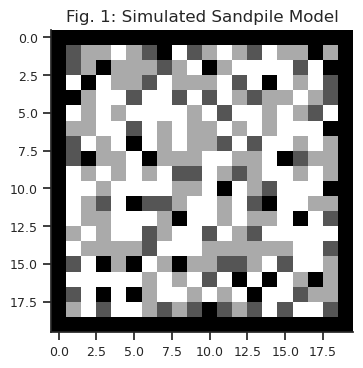

In [4]:
grid, sizes = sandpile()

plt.figure(dpi=100)
plt.imshow(grid, cmap='gray')
plt.title(f'Fig. {fig_n}: Simulated Sandpile Model');
_ = fig_count()

## Q1.
Plot the time vs avalanche size. Describe the dynamics of the avalanche size. How would this plot change as you vary N?

**Answer:**

Since our starting point is an empty grid, the avalanche size starts small and builds up as time passes. As it builds up, the avalanche sizes appear to become random but achieves a certain peak. Comparing the behavior of varying $N$, we can see that the higher the size of the system is, the longer the time it takes for the avalanche size to build up. Moreover, the higher $N$ is, the greater the size of its largest avalanche.

100%|██████████| 5000/5000 [00:01<00:00, 2505.38it/s] 


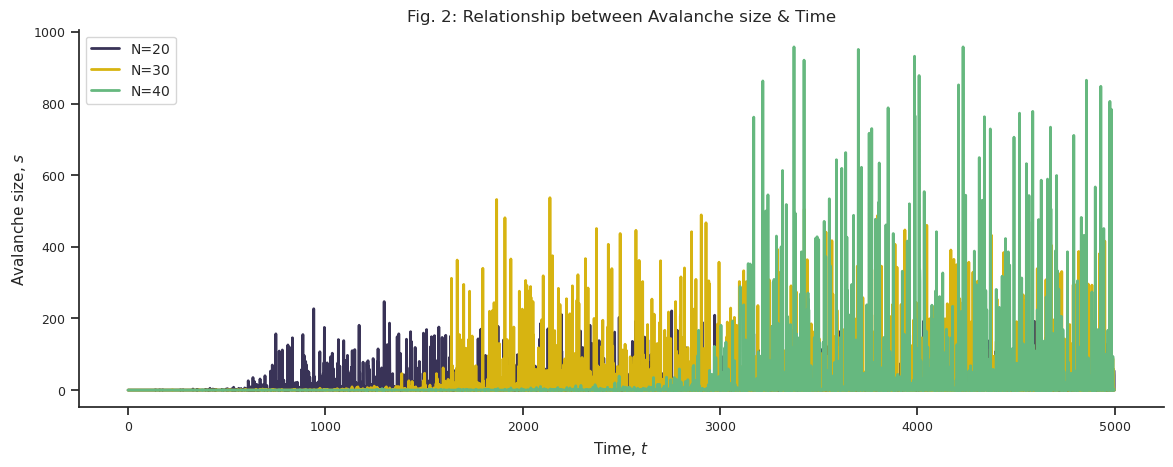

In [5]:
Ns = [20, 30, 40]

fig_title = 'Relationship between Avalanche size & Time'
plot_sizes(Ns, fig_title)

## Q2.
Plot the histogram of avalanche sizes. What does this distribution look like? Try to change the x and y axis in the logarithm to make the plot more obvious.

**Answer:**


The distribution of different avalanche sizes follow a power law with an exponent, $\gamma \approx -1.11$. The resulting log(y)-log(x) plot of a power-law distribution should show a straight line with a negative slope. However, this is not followed for avalanches of size greater than $\approx 10^4$ due to finite-size effects [1] wherein the behavior of the system is limited or influenced by its size.


100%|██████████| 50000/50000 [00:28<00:00, 1755.97it/s]


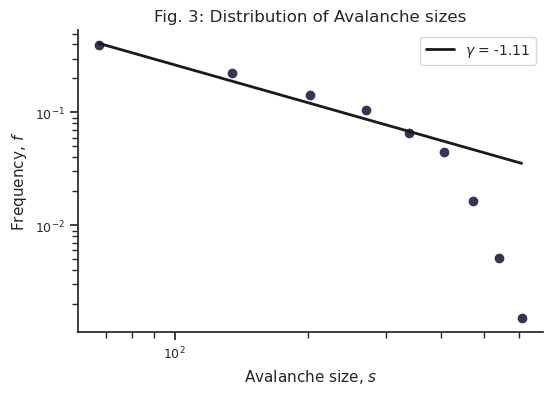

Power Law exponent: -1.1137757449728813


In [6]:
_, s = sandpile(N=30, iterations=50000)

fig_title = 'Distribution of Avalanche sizes'
pow_exp = plot_size_hist(s, fig_title) 
print(f'Power Law exponent: {pow_exp}')

## Q3.
Plot the histogram of waiting time between large avalanches (s > N). What distribution does this show?

**Answer:**

The same observation can be seen for the distribution of waiting time between large avalanches wherein it also follows a power law with an exponent, $\gamma \approx -1.0$. Similarly, for time intervals greater than $\approx 10^2$, the distribution starts to deviate from a power law due to finite-size effects [1].

100%|██████████| 50000/50000 [00:29<00:00, 1718.10it/s]


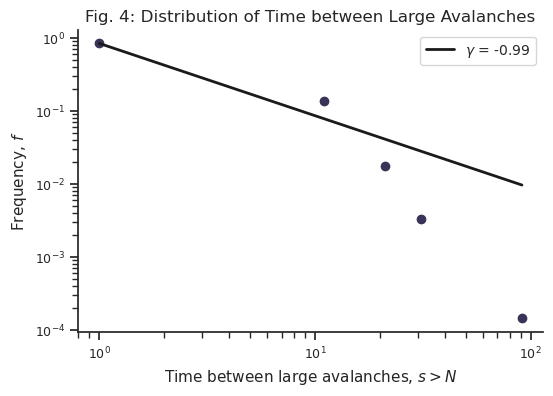

Power Law exponent: -0.9910532058682114


In [7]:
_, sizes = sandpile(N=30, iterations=50000)

fig_title = 'Distribution of Time between Large Avalanches'
pow_exp2 = plot_time_hist(sizes, 30, fig_title)
print(f'Power Law exponent: {pow_exp2}')

## References

[1] Bak, P., Tang, C., & Wiesenfeld, K. (1988). Self-organized criticality. Physical Review, 38(1), 364–374. https://doi.org/10.1103/physreva.38.364